# Pneumonia Single Shot Detection

Karl Heyer

In this project I wanted to apply a single shot detection model I used in a [previous project](https://github.com/kheyer/ML-DL-Projects/blob/master/Single%20Shot%20Detector/Object%20Detection%20Writeup.ipynb) to a different dataset. This dataset comes from Kaggle's [RSNA Pneumonia Detection Challenge](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge).

## Contents

1. Model Architecture
2. Data Setup
3. Prepare Bounding Boxes
4. Create Dataloader
5. Create Anchor Boxes
6. Convolutional Output Functions
7. Loss Function
8. Model Training
9. Viewing Predictions
10. Non-Maximum Suppression
11. Afterthoughts

# 1. Model Architecture

This section gives a brief overview of the data, architecture and loss function used. For more detail, see a [previous project](https://github.com/kheyer/ML-DL-Projects/blob/master/Single%20Shot%20Detector/Object%20Detection%20Writeup.ipynb) of mine using the same model architecture to train an SSD object detection model on Google's [Open Images V4](https://storage.googleapis.com/openimages/web/index.html) dataset.

The architecture used is based of the paper [SSD: Single Shot Multibox Detector](https://arxiv.org/pdf/1512.02325.pdf) by Liu et al. On a high level, this is what the model looks like:[](attachment:ssd_arch.png)

<img src="ssd_arch.png">


A convolutional network processes an input image. The model is trained such that the output activations for the last few convolutional layers to classify and localize objects within the receptive field of the convolution.

Output convolutions are structured as $NxNx(4+c)$ tensors. $NxN$ corresponds to the grid size of the anchor boxes associated with that convolution. The $4+c$ corresponds to 4 values for the predicted bounding box, and c values for each class present in the dataset. When I previously used this architecture, I structured output convolutions to correspond to $4x4$, $2x2$ and $1x1$ anchor boxes. In the paper, Liu et al. used odd valued grid sizes. After some thought, this made a lot of sense. With even grid sizes, your achor boxes always overlap. Each corner of a $4x4$ anchor box grid overlaps perfectly with each box of a $2x2$ grid. This time I decided to use odd valued grid sizes - $10x10$, $5x5$, $3x3$, and $2x2$.

To evaluate the model, each $4+c$ vector in the $NxNx(4+c)$ output is associated to a ground truth anchor box using IOU values to associate predicted boxes with anchor boxes. Ground Truth boxes that do not contain a class are considered background.

The model is evaluated using [focal loss](https://arxiv.org/pdf/1708.02002.pdf), a weighted version of binary cross entropy shown to work particularly well for object detection and localization.

Finally, meaningful predictions are determined using nonmaximum suppression.

# 2. Data Setup

This project uses Pytorch, fast.ai, pydicom and associated libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pydicom

In [3]:
#Set GPU
torch.cuda.set_device(1)

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
PATH = Path('F:/RSNA')

The dataset includes information about the patient, including lung opacity and if the patient has pneumonia (target = 1). Bounding box information is also provided for patients with pneumonia.

In [9]:
df_detailed = pd.read_csv(PATH/'stage_1_detailed_class_info.csv')

In [10]:
df_detailed.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [13]:
df_detailed['class'].value_counts()

No Lung Opacity / Not Normal    11500
Lung Opacity                     8964
Normal                           8525
Name: class, dtype: int64

In [14]:
df_lab = pd.read_csv(PATH/'stage_1_train_labels.csv')

In [15]:
df_lab.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [16]:
df_comb = pd.merge(df_lab, df_detailed, how='inner', on='patientId')

In [17]:
df_comb.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


I struggled to find the right data structure to represent bounding boxes for images with no pneumonia.

Throwing in dummy bounding box values didn't seem to be the right approach. Recall that each predicted bounding box maps back to a ground truth bounding box in a particular location relative to the anchor boxes. Using a generic dummy box for all images without pneumonia would direct the model to localize predictions about healthy patients to a particular place on each image, which seemed a flawed approach.

One approach I would use if I had more time would be to first train a classifier to prescreen images as pneumonia positive or negative before only sending the positive images to the SSD. Since I'm just trying to see how the model does in localization, I decided to make things easy and only use the subset of the data that was pneumonia positive.

In [18]:
df_cat = pd.concat([df_lab, df_detailed.drop('patientId', 1)], 1)

In [19]:
df_cat.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


This was my first time working with DCM files. It's interesting to see how the format is used to encode patient information along with medical images. 

In [35]:
c_dicom = pydicom.read_file('F:/RSNA/stage_1_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm')

In [36]:
c_dicom

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0020) Patient ID                          LO: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

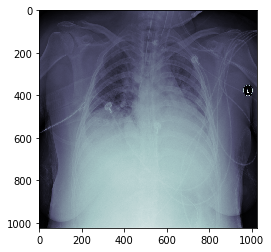

In [39]:
plt.imshow(c_dicom.pixel_array, cmap='bone')

In [41]:
c_dicom.pixel_array.shape

(1024, 1024)

In [55]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, cmap='bone')
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
                  verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [43]:
def bb_hw(a):
    return np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b, c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], code2label[cats[c]], sz=16)
        
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    draw_im(im, im_a)

In [44]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None: prs = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb,clas,prs)):
        if ((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else code2label[id2cat[c]])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [51]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [58]:
gb = df_cat.groupby('patientId')

In [59]:
files = os.listdir(PATH/'stage_1_train_images')

In [78]:
bbs = gb[['patientId', 'x', 'y', 'width', 'height', 'Target']].get_group(files[4][:-4])
bbs

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [90]:
for i in bbs.values:
    print(i)

['00436515-870c-4b36-a041-de91049b9ab4' 264.0 152.0 213.0 379.0 1]
['00436515-870c-4b36-a041-de91049b9ab4' 562.0 152.0 256.0 453.0 1]


In [86]:
from  IPython.core.debugger import set_trace

In [108]:
trn_anno = collections.defaultdict(lambda:[])
for i in bbs.values:
    bb = np.array([i[1+1], i[0+1], i[3+1]+i[1+1]-1, i[2+1]+i[0+1]-1])
    trn_anno[i[0]].append((bb,i[5]))

In [110]:
vals = trn_anno['00436515-870c-4b36-a041-de91049b9ab4']

In [117]:
np.concatenate([vals[0][0], vals[1][0]])

array([152., 264., 530., 476., 152., 562., 604., 817.])

Here's what bounding box data overlayed on a patient image looks like

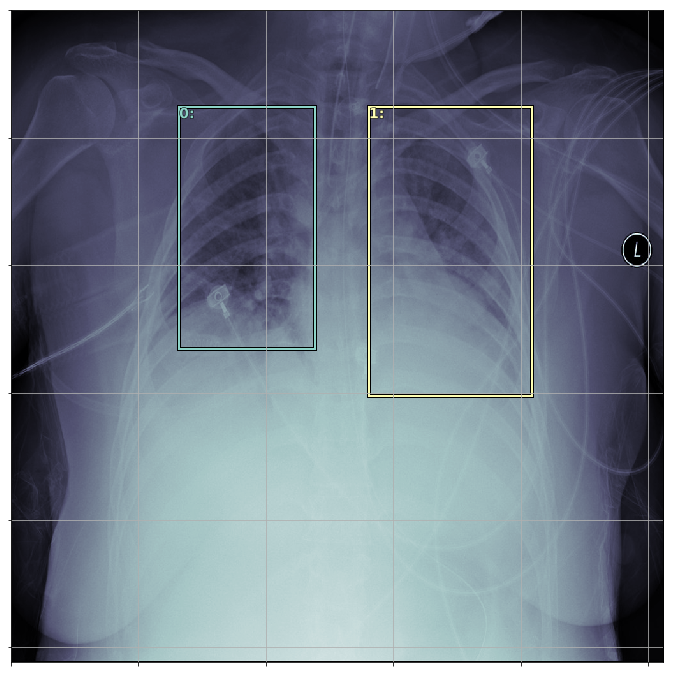

In [118]:
fig, axes = plt.subplots(1,1, figsize=(12,12))
show_ground_truth(axes, c_dicom.pixel_array, np.concatenate([vals[0][0], vals[1][0]]))

The SSD architecture I'm using relies on using a pretrained model as the backbone of the detector. Unfortunately this poses a problem for working with DCM images. The pretrained resnet model I use is trained on Imagenet and designed to take a 3 channel input. The images in the DCM files are single channel. A quick fix is to save each DCM image as a 3 channel png.

In [213]:
for i, fn in enumerate(files):
    if i % 1000 == 0:
        print(i)
    fn_pth = 'F:/RSNA/stage_1_train_images/' + fn
    c_dicom = pydicom.read_file(fn_pth)
    im = Image.fromarray(np.stack([c_dicom.pixel_array, c_dicom.pixel_array, c_dicom.pixel_array], axis=2))
    im.save(PATH/'train_jpegs'/f'{fn[:-4]+ ".png"}', "PNG")

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000


# 3. Prepare Bounding Boxes

We need to get bounding boxes in the right order and file format for feeding to the dataloader. 

In [123]:
trn_fns = dict((i,o[:-4]) for i,o in enumerate(files))

In [125]:
fn_to_id = dict((trn_fns[i], i) for i in list(trn_fns.keys()))

In [127]:
trn_ids = list(trn_fns.keys())

In [132]:
df_pos = df_cat[df_cat.Target == 1]

In [154]:
trn_files = df_pos.patientId.unique()

In [155]:
trn_files[0]

'00436515-870c-4b36-a041-de91049b9ab4'

In [172]:
gb = df_pos.groupby('patientId')
trn_anno = collections.defaultdict(lambda:[])

In [173]:
for fn in trn_files:
    im_id = fn_to_id[fn]
    bbs = gb[['x', 'y', 'width', 'height', 'Target']].get_group(fn)
    
    for i in bbs.values:
        bb = np.array([i[1], i[0], i[3]+i[1]-1, i[2]+i[0]-1])
        trn_anno[im_id].append((bb, i[4]))

In [174]:
len(trn_anno.keys()), len(trn_files)

(5659, 5659)

In [380]:
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

f_model = resnet34
sz = 300
bs = 64

In [381]:
trn_anno[12], trn_anno[4]

([(array([322., 288., 456., 381.]), 1.0),
  (array([299., 547., 463., 665.]), 1.0)],
 [(array([152., 264., 530., 476.]), 1.0),
  (array([152., 562., 604., 817.]), 1.0)])

In [382]:
mc = [[p[1] for p in trn_anno[o]] for o in trn_anno.keys()]

In [383]:
mcs = np.array([np.array([p for p in o]) for o in mc])

In [384]:
mcs[0]

array([1., 1.])

In [385]:
val_idxs = get_cv_idxs(len(trn_files))
((val_mcs, trn_mcs),) = split_by_idx(val_idxs, mcs)

In [386]:
trn_mcs

array([array([1., 1.]), array([1., 1.]), array([1., 1.]), ..., array([1., 1.]), array([1.]), array([1., 1.])],
      dtype=object)

In [387]:
mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_anno.keys()]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

In [388]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_anno.keys()], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

In [389]:
df.fn = df.fn.map(lambda x: x+'.png')

This is how the data will be stored. A CSV file containing filenames paired with bounding boxes.

In [390]:
df.head()

,fn,bbox
0,00436515-870c-4b36-a041-de91049b9ab4.png,152.0 264.0 530.0 476.0 152.0 562.0 604.0 817.0
1,00704310-78a8-4b38-8475-49f4573b2dbb.png,577.0 323.0 680.0 482.0 575.0 695.0 711.0 856.0
2,00aecb01-a116-45a2-956c-08d2fa55433f.png,322.0 288.0 456.0 381.0 299.0 547.0 463.0 665.0
3,00c0b293-48e7-4e16-ac76-9269ba535a62.png,544.0 306.0 787.0 473.0 511.0 650.0 794.0 855.0
4,00f08de1-517e-4652-a04f-d1dc9ee48593.png,184.0 181.0 689.0 386.0 275.0 571.0 750.0 800.0


In [391]:
df.to_csv(MBB_CSV, index=False)

In [392]:
JPEGS = 'train_jpegs'
IMG_PATH = PATH/JPEGS

In [393]:
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [394]:
x, y = next(iter(md.trn_dl))

It looks like the maximum number of bounding boxes in a single image is 3. fast.ai's dataloader automatically pads bounding box data for images with fewer boxes.

In [395]:
y

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 105.,  82., 134., 122.],
        [  0.,   0.,   0.,   0., 172.,  33., 218.,  90., 167., 164., 262., 214.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  80., 157., 234., 226.],
        [  0.,   0.,   0.,   0.,  51., 185., 259., 268.,  39.,  50., 252., 154.],
        [  0.,   0.,   0.,   0.,  99., 177., 164., 249., 117., 105., 175., 147.],
        [  0.,   0.,   0.,   0.,  45.,  50., 259., 128.,  53., 173., 238., 259.],
        [  0.,   0.,   0.,   0.,  54.,  60., 166., 116.,  61., 145., 165., 190.],
        [  0.,   0.,   0.,   0.,  65., 173., 110., 205.,  40.,  63., 119., 132.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  22.,  50., 198., 138.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 142., 159., 175., 208.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 105., 189., 230., 240.],
        [  0.,   0.,   0.,   0., 120.,  54., 173.,  92., 163., 185., 213., 235.],
        [  0.,  

# 4. Create Dataloader

Here we create a dataloader that will pair bounding box and classification data.

In [396]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds, self.y2 = ds, y2
        self.sz = ds.sz
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        return (x, (y, self.y2[i]))

In [397]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [398]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

In [399]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None: prs = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb,clas,prs)):
        if ((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==2 else str(c))
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

Here are what some of the images and bounding boxes in the dataset look like. The boxes seem to target more opaque areas of the lung and avoid clear areas.

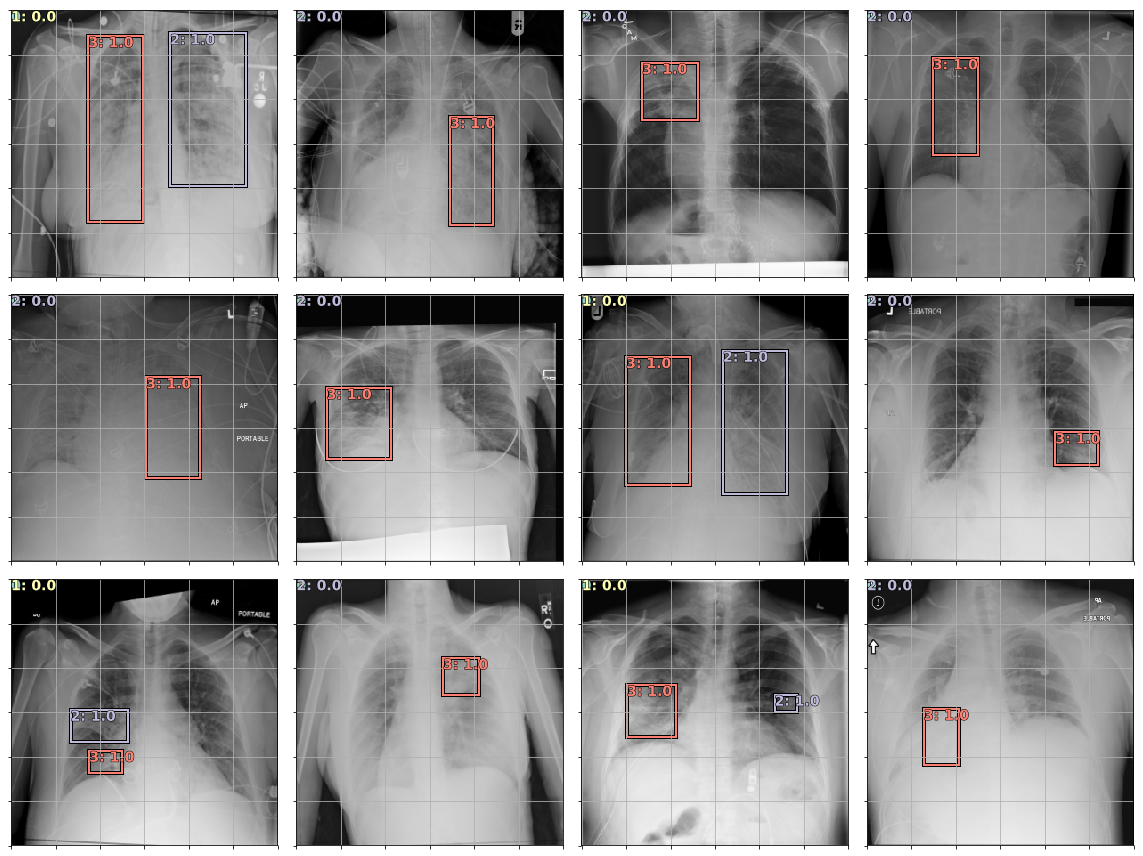

In [401]:
fig, axes = plt.subplots(3, 4, figsize=(16,12))
for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

Just to mke sure everything's working lets look at some data augmentations

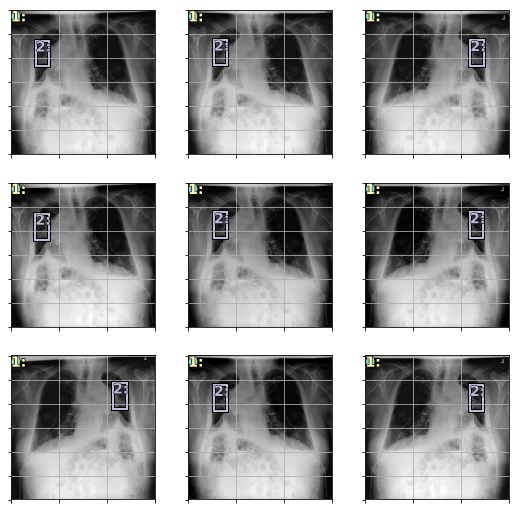

In [402]:
idx=5
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.ds.denorm(to_np(x))[idx]
    show_ground_truth(ax, ima, y[idx])

# 5. Create Anchor Boxes

Here we create our anchor boxes. We use 10x10, 5x5, 3x3 and 2x2 grids. For each anchor box, we create variants in size and scale using 3 different zooms and 3 different aspect ratios. This yields a total of 1242 possible anchor boxes.

In [403]:
anc_grids = [10, 5, 3, 2]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1., 0.5), (0.5, 1.)]
anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]

In [407]:
def hw2corners(ctr, hw):
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [408]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [409]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)

In [410]:
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [411]:
anchors.shape

torch.Size([1242, 4])

In [412]:
a = np.reshape((to_np(anchor_cnr) + to_np(torch.randn(*anchor_cnr.size()))*0.01)*224, -1)

# 6. Convolutional Output Functions

Here we create the second half of the model that will be attached to the pretrained resnet backbone. 

StdConv will be our generic convolutional layer consisting of a convolution of stride 2 followed by relu, batchnorm and dropout.

OutConv uses two separate convolutional output layers to return a tensor for class predictions and a tensor for bounding box predictions for each bounding box represented by the input tensor.

SSD_MultiHead is the actual output function used. It consists of four convolutional layers. The last three convolutional layers feed their output activations into an OutConv layer to produce the final output predictions for all 1242 bounding boxes.

In [413]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x, k):
    bs, nf, gx, gy = x.size()
    x = x.permute(0, 2, 3, 1).contiguous()
    return x.view(bs, -1, nf//k)

In [414]:
class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, (len(id2cat)+1)*k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
    
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
               flatten_conv(self.oconv2(x), self.k)]

In [558]:
drop = 0.4

class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(drop)
        self.sconv0 = StdConv(512, 256, stride=1, drop=drop)
        self.sconv1 = StdConv(256, 256, drop=drop)
        self.sconv2 = StdConv(256, 256, drop=drop)
        self.sconv3 = StdConv(256, 256, drop=drop)

        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        self.out4 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        
        x = self.sconv0(x)
        o1c, o1l = self.out1(x)
        
        x = self.sconv1(x)
        o2c, o2l = self.out2(x)
        
        x = self.sconv2(x)
        o3c, o3l = self.out3(x)
        
        x = self.sconv3(x)
        o4c, o4l = self.out4(x)

        
        return [torch.cat([o1c, o2c, o3c, o4c], dim=1),
               torch.cat([o1l, o2l, o3l, o4l], dim=1)]

In [559]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b):
    return ((b[:, 2] - b[:, 0]) * (b[:, 3] - b[:,1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [560]:
def get_y(bbox, clas):
    bbox = bbox.view(-1, 4) #/sz
    
    if ((bbox[:,2] - bbox[:,0])>0).nonzero().dim() > 1:
        bb_keep = ((bbox[:,2] - bbox[:,0])>0).nonzero()[:,0]
    else:
        bb_keep = ((bbox[:,3] - bbox[:,1])>0).nonzero()[:,0]
    
    bbox = bbox/sz
    
    return bbox[bb_keep], clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:, :2]/2 * grid_sizes) + anchors[:, :2]
    actn_hw = (actn_bbs[:, 2:]/2+1) * anchors[:, 2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it:
        print(prior_overlap)
        
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx):
        gt_idx[o] = i
        
    return gt_overlap, gt_idx

# 7. Loss Function

Here we define the loss function used.

`BCE_Loss` calculates binary cross entropy for class predictions.

`ssd_1_loss` calculates the loss for one set of predictions by mapping those predictions back to ground truth anchor boxes. The output from `ssd_1_loss` is made up of two components - `loc_loss` with measures the absolute error of bounding box predictions and `clas_loss` which uses binary cross entropy to measure classification loss.

`FocalLoss` weights the classification loss by a scaling parameter, as defined by [Liu et al.](https://arxiv.org/pdf/1708.02002.pdf)

In [561]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[to_np(labels.data.cpu())]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, reduction='sum')/self.num_classes
    
    def get_weight(self, x, t):
        return None    

In [562]:
def ssd_1_loss(b_c, b_bb, bbox, clas, print_it=False):
    bbox, clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss/20


def ssd_loss(pred, targ, print_it=False):
    lcs, lls = 0., 0.
    for b_c, b_bb, bbox, clas in zip(*pred, *targ):
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, print_it)
        lls += loc_loss
        lcs += clas_loss
        
    if print_it:
        print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [563]:
def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
                to_np(clas), to_np(prs) if prs is not None else None, thresh)

In [564]:
class FocalLoss(BCE_Loss):
    def get_weight(self, x, t):
        alpha, gamma = 0.25, 1
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

In [565]:
cats = dict((i,o) for i,o in enumerate(df_cat.Target.unique()))

In [567]:
id2cat = list(cats.values())

# 8. Model Training

Here we actually create the model. We add the output function created with `SSD_MultiHead` to a resnet34 model.

In [569]:
head_reg4 = SSD_MultiHead(k, -4.)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head = head_reg4)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [570]:
loss_f = FocalLoss(len(id2cat))

In [572]:
x, y = next(iter(md.val_dl))
x, y = V(x), V(y)

In [573]:
batch = learn.model(x)

In [575]:
batch[1][0].shape

torch.Size([1242, 4])

In [577]:
learn.crit = ssd_loss
lr = 1e-2
lrs = np.array([lr/100, lr/10, lr])

 89%|███████████████████████████████████████████████████████████████        | 63/71 [01:42<00:13,  1.63s/it, loss=37.2]

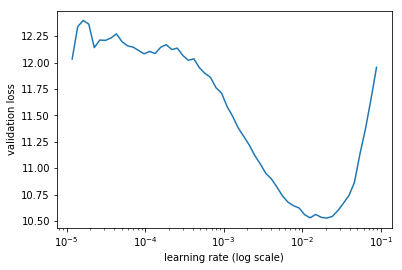

In [578]:
learn.lr_find(lrs/1000, 1.)
learn.sched.plot(1)

In [579]:
learn.fit(lr/5, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                         
    0      8.681838   7.64907   
    1      7.663114   7.015633                                                                                         
    2      7.133892   6.819763                                                                                         
    3      6.86122    6.545638                                                                                         
    4      6.613415   6.466112                                                                                         
    5      6.484725   6.415459                                                                                         
    6      6.319922   6.332043                                                                                         
    7      6.220591   6.288885                                                                                         
    8  

[6.153796683782819]

In [580]:
learn.freeze_to(-2)
learn.fit(lrs/20, 1, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                         
    0      6.298733   6.144612  
    1      5.992353   5.90239                                                                                          
    2      5.703172   5.796862                                                                                         
    3      5.478346   5.808079                                                                                         
    4      5.275911   5.767735                                                                                         
    5      5.06453    5.810424                                                                                         
    6      4.930684   5.828168                                                                                         
    7      4.738391   5.821309                                                                                         
    8  

[5.881258921323889]

# 9. Viewing Predictions

Here we can look at the raw predictions from the model. You can see how several bounding boxes are predicted for the same general area.

In [369]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app
C:\Users\GATEWAY\Anaconda2\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in P

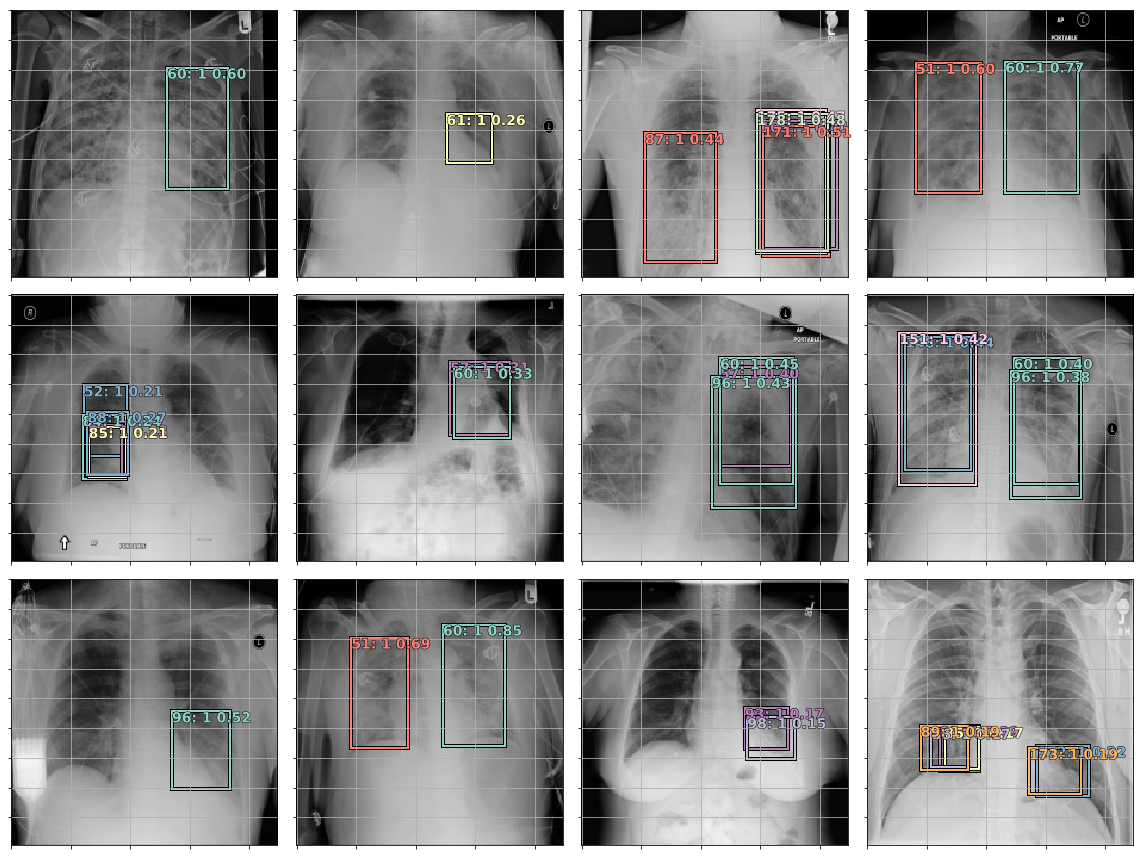

In [370]:
plot_results(0.75)

# 10. Non-Maximum Suppression

We can use non-maximum suppression to remove the redundant bounding boxes and only take the most confident predictions.

In [371]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [372]:
x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
x = to_np(x)

In [373]:
def show_nmf(idx, IOU, conf):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > conf
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, IOU, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(6,6))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

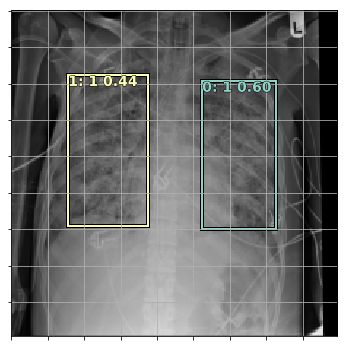

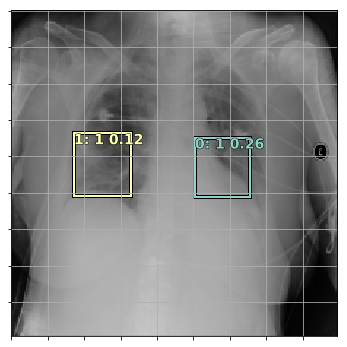

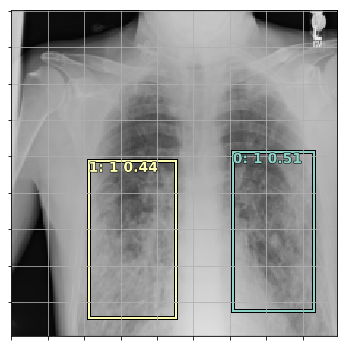

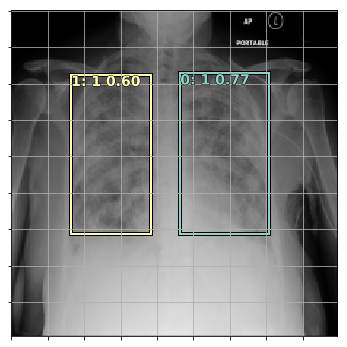

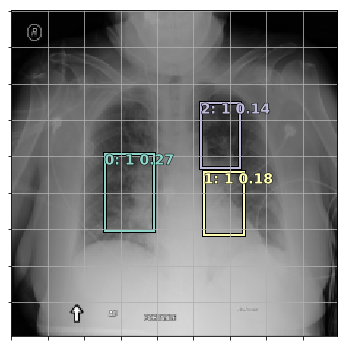

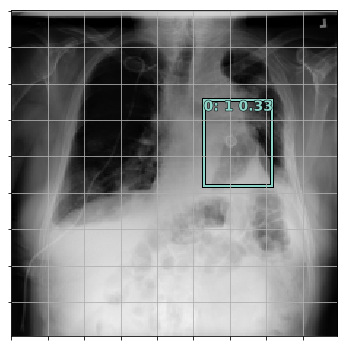

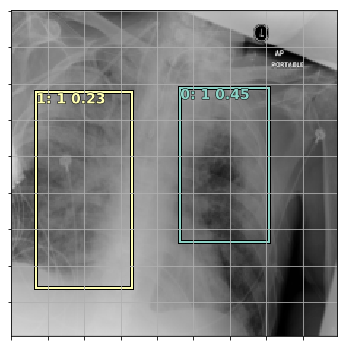

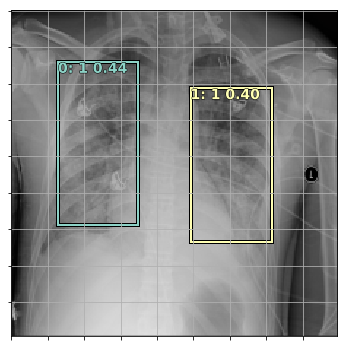

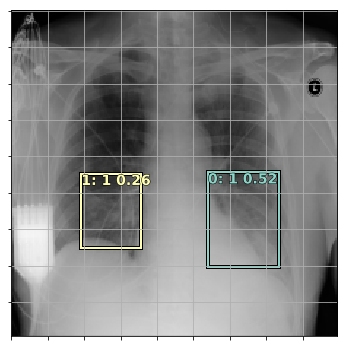

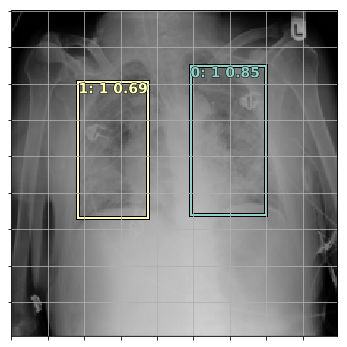

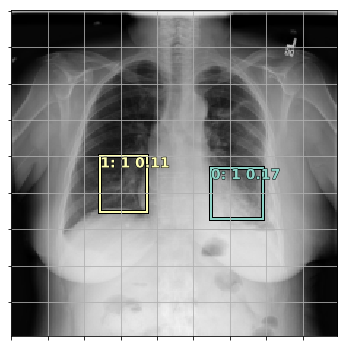

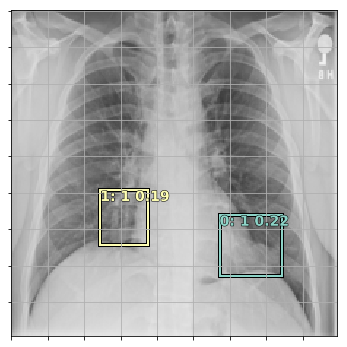

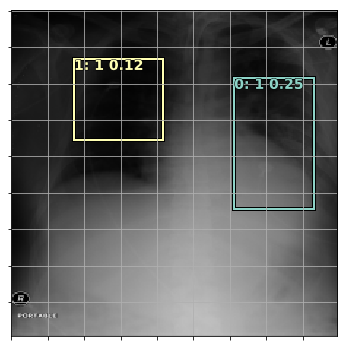

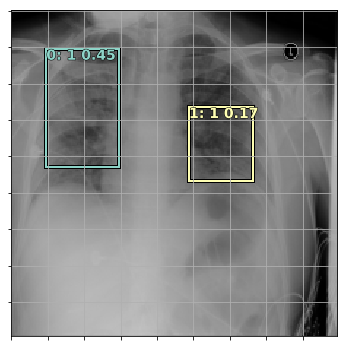

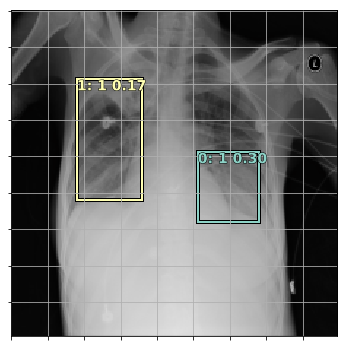

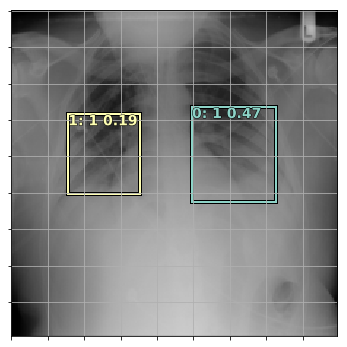

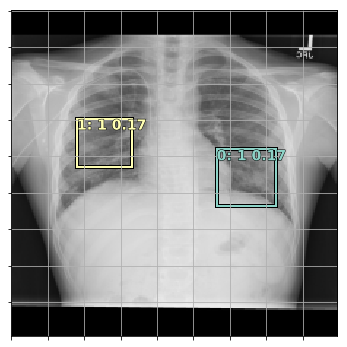

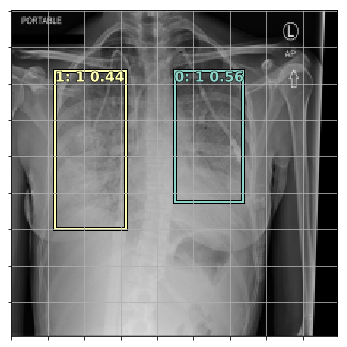

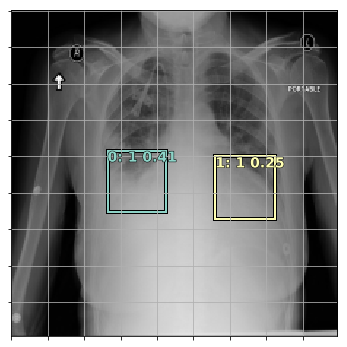

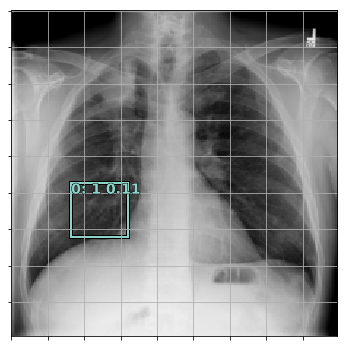

In [379]:
for i in range(20):
    try:
        show_nmf(i, 0.1, 0.1)
        
    except:
        pass

# 11. Afterthoughts

This was a fun quick project to do while I sit through some very long epochs on another project I'm working on. It's cool to see basically the same model I used for standard object detection apply itself to medical imaging. The predictions don't look half bad. I'm no doctor but most of the predicted bounding boxes target opaque lung areas reminiscent of the training images. There are a few boxes that (to my knowledge) are completely wrong - boxes that bound black/empty areas of the lung.

The model could certainly be improved a lot. I avoided a lot of difficulty by only training on pneumonia positive images. My intuition is that with the proper data structure for applying bounding boxes to negative images, this same architecture could work on all the images in the dataset.